In [15]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

df = pd.read_csv('../data/cal_fire_data_cleaned.csv')
target = 'Destroyed'
X = df.drop(columns=[target])
y = df[target]

categorical_cols = X.select_dtypes(include='object').columns.tolist()

numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns.difference([target])

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ],
    remainder='passthrough'  
)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(random_state=216))
])

param_grid = {
    'classifier__criterion': ['gini', 'entropy'],
    'classifier__max_depth': [5, 10, 15, 20, None],
    'classifier__min_samples_split': [2, 4, 6, 8, 10, 12],
    'classifier__min_samples_leaf': [1, 2, 4, 8]
}

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=216
)

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=216)
grid_search = GridSearchCV(pipeline, param_grid, cv=kfold, verbose=2, n_jobs=-1)
grid_search.fit(X_train, y_train)

print("best_params:", grid_search.best_params_)
y_pred = grid_search.best_estimator_.predict(X_test)
print(classification_report(y_test, y_pred))


Fitting 5 folds for each of 240 candidates, totalling 1200 fits
[CV] END classifier__criterion=gini, classifier__max_depth=5, classifier__min_samples_leaf=1, classifier__min_samples_split=2; total time=   0.5s
[CV] END classifier__criterion=gini, classifier__max_depth=5, classifier__min_samples_leaf=1, classifier__min_samples_split=2; total time=   0.5s
[CV] END classifier__criterion=gini, classifier__max_depth=5, classifier__min_samples_leaf=1, classifier__min_samples_split=2; total time=   0.6s
[CV] END classifier__criterion=gini, classifier__max_depth=5, classifier__min_samples_leaf=1, classifier__min_samples_split=2; total time=   0.6s
[CV] END classifier__criterion=gini, classifier__max_depth=5, classifier__min_samples_leaf=1, classifier__min_samples_split=2; total time=   0.6s
[CV] END classifier__criterion=gini, classifier__max_depth=5, classifier__min_samples_leaf=1, classifier__min_samples_split=4; total time=   0.6s
[CV] END classifier__criterion=gini, classifier__max_depth=5

In [16]:
from sklearn.metrics import accuracy_score, balanced_accuracy_score

best_tree = grid_search.best_estimator_
preds = best_tree.predict(X_test)
baseline_test_acc = accuracy_score(y_test, preds)
baseline_test_balanced_acc = balanced_accuracy_score(y_test, preds)
print(baseline_test_acc)
print(baseline_test_balanced_acc)


0.8859546623042767
0.8764443361784391


In [17]:
probabilities = best_tree.predict_proba(X_test)
print(probabilities)


[[0.16666667 0.83333333]
 [0.04846939 0.95153061]
 [0.02528902 0.97471098]
 ...
 [1.         0.        ]
 [1.         0.        ]
 [1.         0.        ]]


In [18]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score


In [19]:
print(precision_score(y_test, best_tree.predict(X_test), average=None))
print(recall_score(y_test, best_tree.predict(X_test), average=None))
print(f1_score(y_test, best_tree.predict(X_test), average=None))


[0.8886385  0.88153418]
[0.92512219 0.82776648]
[0.90651341 0.85380467]


In [20]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay


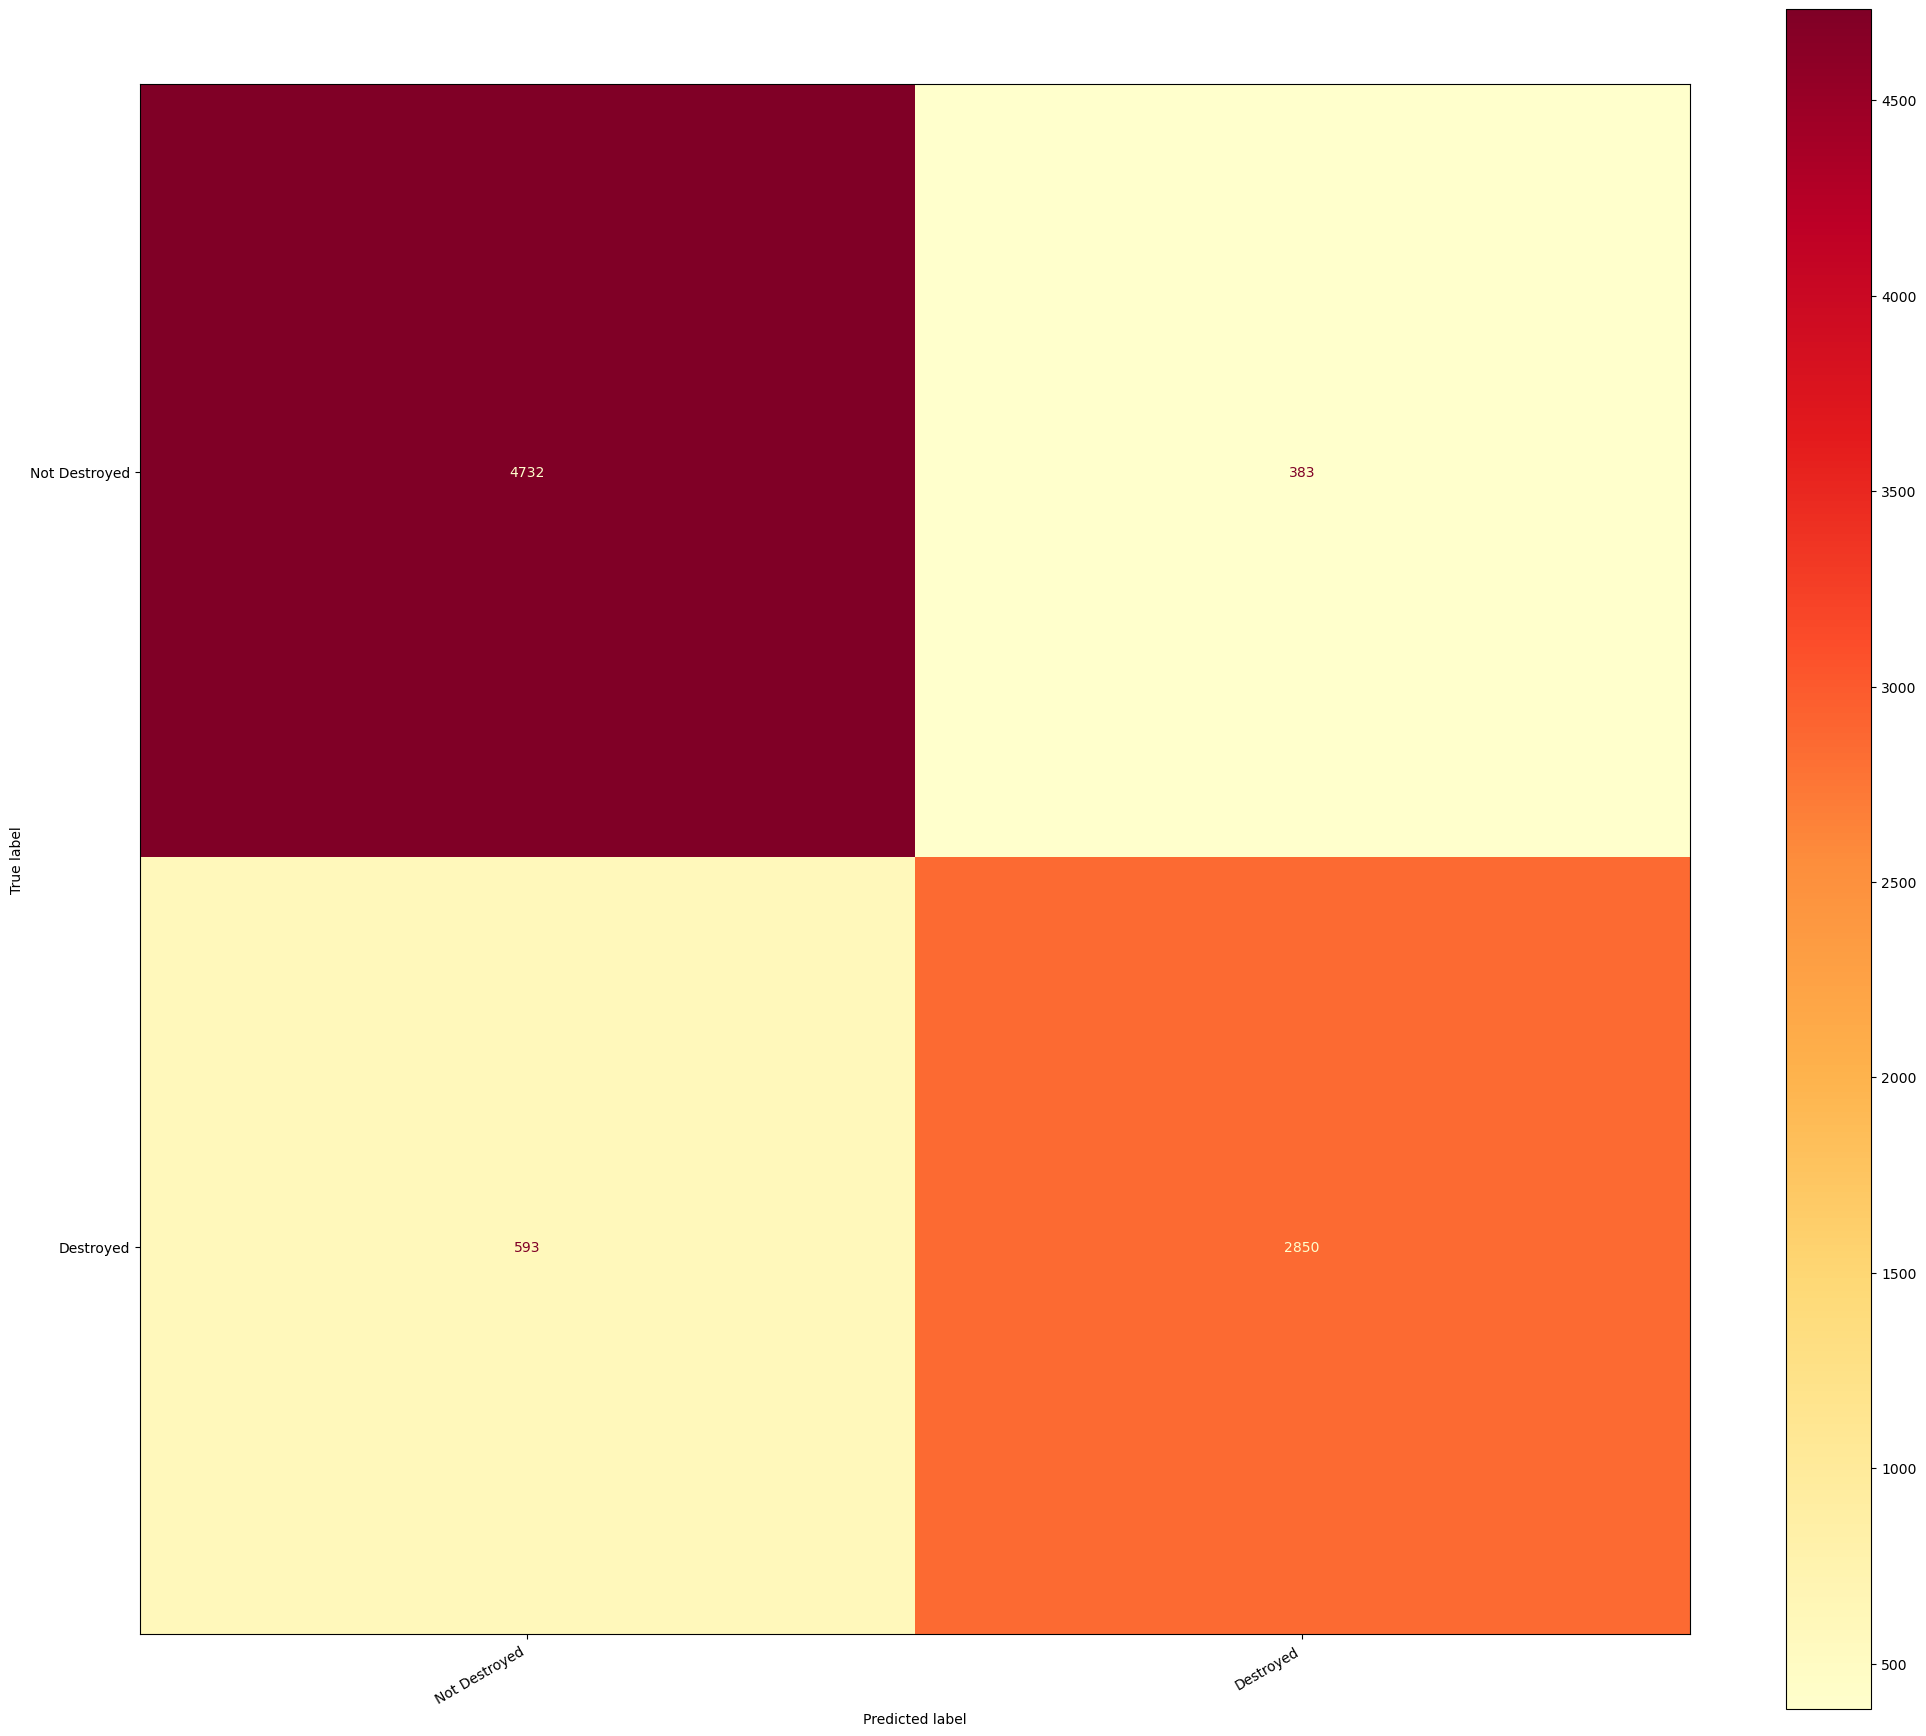

In [21]:
cm = confusion_matrix(y_test, best_tree.predict(X_test))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Destroyed', 'Destroyed'])
fig, ax = plt.subplots(figsize=(25, 25))
disp.plot(ax=ax, cmap='YlOrRd')
fig.autofmt_xdate()
plt.show()


In [23]:
from IPython.display import display
feature_df = pd.DataFrame({'feature': pd.get_dummies(X, columns=X.select_dtypes('object').columns).columns, 'importance': best_tree['classifier'].feature_importances_})
display(feature_df)


,feature,importance
0,Assessed Improved Value (parcel),0.000000
1,Latitude,0.000045
2,Longitude,0.000678
3,Age,0.000000
4,* Structure Type_Church,0.000000
5,* Structure Type_Commercial Building Multi Story,0.000000
6,* Structure Type_Commercial Building Single Story,0.009208
7,* Structure Type_Hospital,0.000241
8,* Structure Type_Infrastructure,0.000000
9,* Structure Type_Mixed Commercial/Residential,0.000977
